
<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<img src="https://keras.io/img/logo-k-keras-wb.png" width="200" alt="Keras" />
<!--- @wandbcode{zero_dce_video} -->

# Zero-DCE for low-light image enhancement

**Author:** [Soumik Rakshit](http://github.com/soumik12345)<br>
**Description:** Implementing Zero-Reference Deep Curve Estimation for low-light image enhancement.<br>
*Modified for the video by:* [Ivan Goncharov](http://github.com/ivangrov)  <br>

## Introduction

**Zero-Reference Deep Curve Estimation** or **Zero-DCE** formulates low-light image
enhancement as the task of estimating an image-specific
[*tonal curve*](https://en.wikipedia.org/wiki/Curve_(tonality)) with a deep neural network.
In this example, we train a lightweight deep network, **DCE-Net**, to estimate
pixel-wise and high-order tonal curves for dynamic range adjustment of a given image.

Zero-DCE takes a low-light image as input and produces high-order tonal curves as its output.
These curves are then used for pixel-wise adjustment on the dynamic range of the input to
obtain an enhanced image. The curve estimation process is done in such a way that it maintains
the range of the enhanced image and preserves the contrast of neighboring pixels. This
curve estimation is inspired by curves adjustment used in photo editing software such as
Adobe Photoshop where users can adjust points throughout an image’s tonal range.

Zero-DCE is appealing because of its relaxed assumptions with regard to reference images:
it does not require any input/output image pairs during training.
This is achieved through a set of carefully formulated non-reference loss functions,
which implicitly measure the enhancement quality and guide the training of the network.

### References

- [Zero-Reference Deep Curve Estimation for Low-Light Image Enhancement](https://arxiv.org/pdf/2001.06826.pdf)
- [Curves adjustment in Adobe Photoshop](https://helpx.adobe.com/photoshop/using/curves-adjustment.html)

## Downloading LOLDataset

The **LoL Dataset** has been created for low-light image enhancement. It provides 485
images for training and 15 for testing. Each image pair in the dataset consists of a
low-light input image and its corresponding well-exposed reference image.

In [ ]:
!pip install -q wandb

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 145 kB 51.2 MB/s 
     |████████████████████████████████| 181 kB 35.9 MB/s 
     |████████████████████████████████| 63 kB 269 kB/s 


In [ ]:
import wandb
from wandb.keras import WandbCallback

# Downloading Lol dataset using W&B Artifacts

In [ ]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
run = wandb.init()
artifact = run.use_artifact('ivangoncharov/Low Light Enhancement with Zero-DCE/Lol_Dataset:v0', type='dataset')
artifact_dir = artifact.download()
artifact_path = os.path.join(artifact_dir, "lol_dataset.zip")
!unzip $artifact_path

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact Lol_Dataset:v0, 331.09MB. 1 files... Done. 0:0:0


Archive:  ./artifacts/Lol_Dataset:v0/lol_dataset.zip
   creating: lol_dataset/
   creating: lol_dataset/eval15/
   creating: lol_dataset/eval15/high/
  inflating: lol_dataset/eval15/high/748.png  
  inflating: lol_dataset/eval15/high/665.png  
  inflating: lol_dataset/eval15/high/111.png  
  inflating: lol_dataset/eval15/high/493.png  
  inflating: lol_dataset/eval15/high/22.png  
  inflating: lol_dataset/eval15/high/23.png  
  inflating: lol_dataset/eval15/high/669.png  
  inflating: lol_dataset/eval15/high/547.png  
  inflating: lol_dataset/eval15/high/778.png  
  inflating: lol_dataset/eval15/high/55.png  
  inflating: lol_dataset/eval15/high/179.png  
  inflating: lol_dataset/eval15/high/780.png  
  inflating: lol_dataset/eval15/high/79.png  
  inflating: lol_dataset/eval15/high/146.png  
  inflating: lol_dataset/eval15/high/1.png  
  inflating: lol_dataset/eval15/.DS_Store  
   creating: lol_dataset/eval15/low/
  inflating: lol_dataset/eval15/low/748.png  
  inflating: lol_dataset

## Creating a TensorFlow Dataset

We use 300 low-light images from the LoL Dataset training set for training, and we use
the remaining 185 low-light images for validation. We resize the images to size `256 x
256` to be used for both training and validation. Note that in order to train the DCE-Net,
we will not require the corresponding enhanced images.

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400


def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image


def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))


train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


# Visualizing 100 train images from the Lol (low light) dataset

In [ ]:
wandb.init(project="low_light_zero_DCE", job_type="EDA")

table = wandb.Table(columns=["Low light", "High light"])

for img_path in train_low_light_images[:100]:
  #print(img_path)
  lowlight_image = Image.open(img_path)
  highlight_image = Image.open(img_path.replace("low", "high"))
  table.add_data(
        wandb.Image(np.array(lowlight_image)),
        wandb.Image(np.array(highlight_image)),
    )


wandb.log({"Dataset table": table})

wandb.finish()

## The Zero-DCE Framework

The goal of DCE-Net is to estimate a set of best-fitting light-enhancement curves
(LE-curves) given an input image. The framework then maps all pixels of the input’s RGB
channels by applying the curves iteratively to obtain the final enhanced image.

### Understanding light-enhancement curves

A ligh-enhancement curve is a kind of curve that can map a low-light image
to its enhanced version automatically,
where the self-adaptive curve parameters are solely dependent on the input image.
When designing such a curve, three objectives should be taken into account:

- Each pixel value of the enhanced image should be in the normalized range `[0,1]`, in order to
avoid information loss induced by overflow truncation.
- It should be monotonous, to preserve the contrast between neighboring pixels.
- The shape of this curve should be as simple as possible,
and the curve should be differentiable to allow backpropagation.

The light-enhancement curve is separately applied to three RGB channels instead of solely on the
illumination channel. The three-channel adjustment can better preserve the inherent color and reduce
the risk of over-saturation.

![](https://li-chongyi.github.io/Zero-DCE_files/framework.png)

### DCE-Net

The DCE-Net is a lightweight deep neural network that learns the mapping between an input
image and its best-fitting curve parameter maps. The input to the DCE-Net is a low-light
image while the outputs are a set of pixel-wise curve parameter maps for corresponding
higher-order curves. It is a plain CNN of seven convolutional layers with symmetrical
concatenation. Each layer consists of 32 convolutional kernels of size 3×3 and stride 1
followed by the ReLU activation function. The last convolutional layer is followed by the
Tanh activation function, which produces 24 parameter maps for 8 iterations, where each
iteration requires three curve parameter maps for the three channels.

![](https://i.imgur.com/HtIg34W.png)

In [ ]:

def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)


## Loss functions

To enable zero-reference learning in DCE-Net, we use a set of differentiable
zero-reference losses that allow us to evaluate the quality of enhanced images.

### Color constancy loss

The *color constancy loss* is used to correct the potential color deviations in the
enhanced image.

In [ ]:

def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))


### Exposure loss

To restrain under-/over-exposed regions, we use the *exposure control loss*.
It measures the distance between the average intensity value of a local region
and a preset well-exposedness level (set to `0.6`).

In [ ]:

def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))


### Illumination smoothness loss

To preserve the monotonicity relations between neighboring pixels, the
*illumination smoothness loss* is added to each curve parameter map.

In [ ]:

def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size


### Spatial consistency loss

The *spatial consistency loss* encourages spatial coherence of the enhanced image by
preserving the contrast between neighboring regions across the input image and its enhanced version.

In [ ]:

class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down


### Deep curve estimation model

We implement the Zero-DCE framework as a Keras subclassed model.

In [ ]:

class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


In [ ]:
wandb.init(project="low_light_zero_DCE", job_type="training")

wandb: Currently logged in as: ivangoncharov. Use `wandb login --relogin` to force relogin


## Training

In [ ]:
wandb.config.learning_rate = 1e-4 

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
25/25 [==============================] - 22s 303ms/step - total_loss: 5.9886 - illumination_smoothness_loss: 3.0585 - spatial_constancy_loss: 1.9968e-05 - color_constancy_loss: 0.0027 - exposure_loss: 2.9274 - val_total_loss: 5.1403 - val_illumination_smoothness_loss: 2.1393 - val_spatial_constancy_loss: 1.9763e-05 - val_color_constancy_loss: 4.0618e-04 - val_exposure_loss: 3.0005 - _timestamp: 1653871424.0000 - _runtime: 74.0000
Epoch 2/50
25/25 [==============================] - 7s 292ms/step - total_loss: 4.8340 - illumination_smoothness_loss: 1.9148 - spatial_constancy_loss: 3.5805e-05 - color_constancy_loss: 0.0028 - exposure_loss: 2.9164 - val_total_loss: 4.2994 - val_illumination_smoothness_loss: 1.3093 - val_spatial_constancy_loss: 3.7667e-05 - val_color_constancy_loss: 4.6147e-04 - val_exposure_loss: 2.9896 - _timestamp: 1653871431.0000 - _runtime: 81.0000
Epoch 3/50
25/25 [==============================] - 7s 289ms/step - total_loss: 4.2285 - illumination_smoothnes

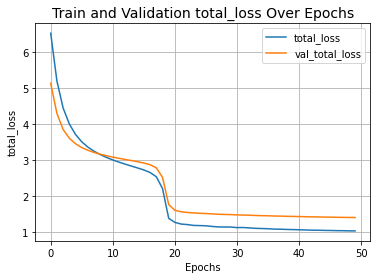

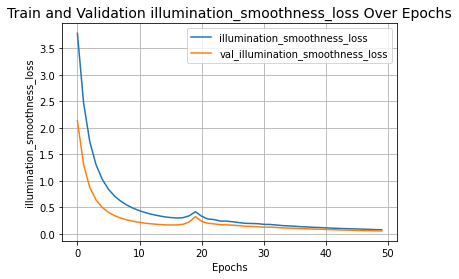

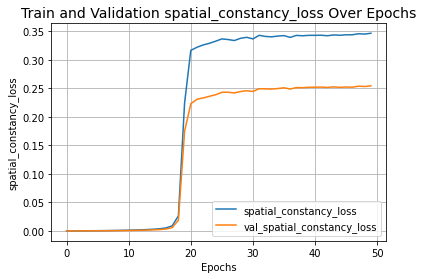

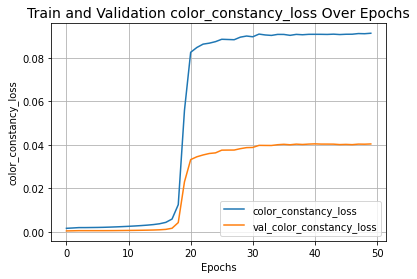

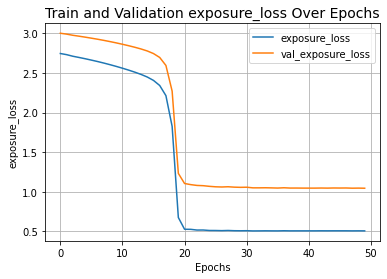

In [ ]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=wandb.config.learning_rate) 
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[WandbCallback()])


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

## Inference

In [ ]:

def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image


### Inference on test images and visualize results using W&B Tables


In [ ]:
wandb.init(project="low_light_zero_DCE", job_type="predictions")

table = wandb.Table(columns=["Original", "PIL Autocontrast", "Enhanced"])
for val_image_file in test_low_light_images:
    original_image = Image.open(val_image_file)
    enhanced_image = infer(original_image)
    table.add_data(
        wandb.Image(np.array(original_image)),
        wandb.Image(np.array(ImageOps.autocontrast(original_image))),
        wandb.Image(np.array(enhanced_image))
    )

wandb.log({"Inference Table": table})

wandb.finish()
    

color_constancy_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▇▇██████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
exposure_loss,████████▇▇▇▇▇▇▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
illumination_smoothness_loss,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
spatial_constancy_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▇███████████████████████
total_loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_color_constancy_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▇▇▇▇▇███████████████████
val_exposure_loss,█████████▇▇▇▇▇▇▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_illumination_smoothness_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_spatial_constancy_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▇▇▇▇████████████████████
val_total_loss,█▆▆▅▅▅▄▄▄▄▄▄▄▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
zero_dce_model.dce_model.save("model.h5")